### This notebook illustrates the use of the method on a real dataset. 

In [1]:
from SegmentACF import InitialiseLagList,getCentralLagArray,getWelchACF,getSelectionArray,getCorrection,getPhi,CalculateLags, GenerateCombs,plotCombs
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import get_window
from obspy import UTCDateTime,Stream,Trace
from obspy.clients.fdsn import Client
from obspy.core import read
import os
import warnings
warnings.filterwarnings("ignore")

### Download a 2 years dataset using the obspy Client. This cell can be skipped by reading the data in the following cell.

In [ ]:
pre_filt = (5E-5, 1E-4, 1E-3, 5E-2)  # Pre-filter coefficients for instrument response removal

ts = UTCDateTime("2010-01-01T00:00:00.000")  # Start time for waveform retrieval
te = UTCDateTime("2014-01-01T00:00:00.000")  # End time for waveform retrieval

client_name = 'IRIS'  # Default client for waveform retrieval
client = Client(client_name)



st = Stream()  # Stream object to store the retrieved waveform data
station_code = "BFO"  # Station code for the waveform data retrieval
channel = "VHZ"  # Here we only use the long periods to study the hum (LHZ = 1 sec sampling rate, VHZ = 0.1 sec sampling rate)
inv = client.get_stations(network="II", station=station_code, level="response")
station = inv[0][0]  # inventory station object
network = inv[0].code  # Network object from the inventory


location = station.channels[0].location_code  # Get the location code

# Here we loop 5 times to ensure we can retrieve the data because the client request may fail.
for i in range(5):

    try:
        st_tmp = client.get_waveforms(network, station_code, location ,channel, ts, te, attach_response=True)
        print(f"network : {network}, station code : {station_code}, location : {location}")

        # Merge the waveform data into the stream object
        st_tmp.merge(method=1,fill_value='interpolate')
        st_tmp.resample(1/50)  # Resample the data to second sampling rate
        # If only one trace is present, remove the instrument response and append it to the stream object
        if len(st_tmp) == 1:
            for tr in st_tmp:
                tr.remove_response(inv,output='ACC', pre_filt=pre_filt)
                st += st_tmp
                break #Supposed to have a single trace in the stream object
            
        break  # Exit the loop if data retrieval is successful
                
    except Exception as e:
        pass
        print(f"Error retrieving data for station {station_code}")
        continue
print(st)
os.makedirs("Data",exist_ok=True)  # Create a directory named 'Data' if it doesn't exist
st.write("Data/BFO_VHZ_2010-2014_selection.SAC", format="SAC")  # Write the stream data to a MiniSEED file

network : II, station code : BFO, location : 00
1 Trace(s) in Stream:
II.BFO.00.VHZ | 2010-01-01T00:00:00.620300Z - 2013-12-31T23:58:20.620300Z | 50.0 s, 2524607 samples


### Data selection for the seismic hum : 

- Two kind of selections : amplitude selection based on the hum known amplitude
- Earthquake excited normal mode selection based on an EQ catalog

In [14]:
import SegmentACF
from importlib import reload
reload(SegmentACF)
from SegmentACF import InitialiseLagList,getCentralLagArray,getWelchACF,getSelectionArray,getCorrection,getPhi,getQ_P,getSelectionListFull,getFourierSubSegments
## First, we need to decide the lengths L and ell which will decide the numbers Q and P.
ts = UTCDateTime("2010-01-01T00:00:00.000")  # Start time for waveform retrieval
te = UTCDateTime("2012-01-01T00:00:00.000")  # End time for waveform retrieval

L = 2**14 # Around two days of data , when df = 0.1 Hz
ell = 2**10 # Around 12 hours of data, when df = 0.1 Hz
st = read("Data/BFO_VHZ_2010-2012_selection.SAC")  # Read the stream data from the MiniSEED file
# We need to calculate the selection list to ultimately correct for zeta. Thus we first shrink the whole data set in sub-segments of length ell.

#st.write("Data/BFO_VHZ_2010-2014_selection.SAC", format="SAC")  # Write the selection list to a MiniSEED file
psd_segments, freqs,segment_times_seconds = getFourierSubSegments(st[0], L,ell,no_pad=True)  # Get the Fourier transforms of each sub-segment using vectorized function

Total number of points : 1831681, Points used: 1825280
Number of sub-segment in the used data: 3563 
Number of sub-segments in the whole data: 3575


In [15]:
# Define the thresholds and frequency ranges for the different band
thresholds = [(1e-19, 5e-18),
             (1e-19, 3e-18),

            ]
freq_ranges = [(2e-3,7.5e-3),
               (1e-3,2e-3),
               ]

# Get the freq masks
freq_masks = [(freqs > fmin) & (freqs < fmax) for (fmin, fmax) in freq_ranges]

# Vectorized mean PSD per band and segment
mean_psds = np.array([
    psd_segments[:, mask].mean(axis=1)
    for mask in freq_masks
])  # shape (n_ranges, n_subseg)

selection_indexes = getSelectionListFull(ts,te,segment_times_seconds,mean_psds, thresholds,eqCatalog=False,max_mag=4.5)  # Get the selection list based on mean PSDs and thresholds 

Number of sub-segments discarded based on earthquake catalog: 0
Number of sub-segments discarded based on thresholds: 1098
Total number of sub-segments discarded: 1098
Proportion of discarded segments: 31.0 %


In [ ]:
import pyfftw as fftw
from numpy.lib.stride_tricks import sliding_window_view


In [112]:
import SegmentACF
from importlib import reload
reload(SegmentACF)
from SegmentACF import InitialiseLagList,getCentralLagArray,getWelchACF,getSelectionArray,getCorrection,ProcessData

def ProcessData(data,Q,ell,L,selection_array,selection_array_i3,Correction,central_lag_list,central_lag_ij_array):
    fftw.interfaces.cache.enable()  # cache FFT plans
    init = fftw.empty_aligned((Q,4,2*L-1), dtype='float32') # need the -1 because the last comb in the data might not be full and thus lead to error.
    init[:]= 0  # Initialize the array to zeros
    process = fftw.builders.fft(init)

    combs= GenerateCombs(ell,L)  # Generate the comb functions for Q segments, each of length ell and total length L

    mute_mask = np.ones((Q, 4, L))

    npts_used = (L-ell//2)*(Q+1)

    for i in range(4):
        if i<3:
            selection_list = selection_array[:, i]
            len_ = selection_list.shape[1]  # Length of the selection list for the current comb
        else:
            selection_list = selection_array_i3[:,0]
            len_ = selection_list.shape[1]
        for j in range(len_):
            mute_mask[:, i, i*ell//2 + 2*j*ell:i*ell//2 + 2*(j+1)*ell] *= selection_list[:,j][:, np.newaxis]
        
    #### VECTORIZED OPERATION FOR THE SEGMENT MUTING ####
    comb_array = np.tile(combs, (Q, 1, 1))  # (Q, 4, L)
    comb_array *= mute_mask  # now all Q combs are pre-masked

    # Roll the data segments according to the shifts

    step=(L - ell//2) # Take the overlap into account (half sub-segment length to ensure a flat equivalent windowing taper)
    data_rolled = np.zeros((Q, 4, L))
    segments = sliding_window_view(data[:npts_used], window_shape=L)[::step].copy()
    for q in range(Q):
        data_rolled[q] = np.tile(segments[q], (4, 1))  # shape (Q, 4, L)

    ### Vectorized calculation of the fourrier transforms
    segments = comb_array * data_rolled  # shape (Q, 4, L)
    #fft_segments = fftw.interfaces.numpy_fft.fft(np.pad(segments, ((0,0),(0,0),(0,L-1))), axis=-1) #Shape (Q, 4, 2*L-1)
    init[:,:,0:L] = segments  # Fill the FFTW plan with the segments
    fft_segments = process(init)  # Apply the FFTW plan to compute the FFT
    print("FFT segments shape:", fft_segments.shape)
    phi,zeta_k = getPhi_batch(Correction,central_lag_list, central_lag_ij_array,fft_segments, ell, L,batch_size=100)
    
    return phi,zeta_k

def getPhi_batch(Correction, central_lag_list, central_lag_ij_array, fft_segments, len1, len2, batch_size=50):
    """Batch-wise computation of phi_k and zeta_k"""
    nLagBins = len(central_lag_list)
    nfft = fft_segments.shape[-1]
    n_segments = fft_segments.shape[0]
    zeta_separate = np.zeros((nLagBins, 2*len2-1))  # (nLagBins, 2*len2-1)

    lags_acf = np.arange(-len2 + 1, len2)
    lag_to_idx = {lag: k for k, lag in enumerate(central_lag_list)}

    # Loop over batches
    norm_factor= 0 
    for i_start in range(0, n_segments, batch_size):
        i_end = min(i_start + batch_size, n_segments)
        batch_fft = fft_segments[i_start:i_end]  # (batch_size, 4, nfft)
        #init = fftw.empty_aligned((batch_fft.shape[0], nfft), dtype='complex64')  # Initialize the FFTW plan
        #init[:,:] = 0
        #process = fftw.builders.ifft(init)  # Create the inverse FFTW plan
        for i in range(4):
            auto_spec = batch_fft[:, i, :] * np.conj(batch_fft[:, i, :])
            inverse_fft = np.fft.ifft(auto_spec, axis=-1).real
            #inverse_fft = fftw.interfaces.numpy_fft.ifft(auto_spec, axis=-1).real
            #inverse_fft = process(auto_spec)  # Apply the inverse FFTW plan to compute the IFFT
            inverse_fft = np.fft.fftshift(inverse_fft, axes=-1)

            central_lags = central_lag_ij_array[i, i]
            for lag in central_lags:
                central_idx = lag_to_idx[lag]
                acf_index = np.where(lags_acf == lag)[0][0]
                extract = np.mean(inverse_fft[:, acf_index-len1 : acf_index+len1+1], axis=0)
                temp = np.zeros((2*len2-1))
                temp[acf_index-len1 : acf_index+len1+1] = extract
                zeta_separate[central_idx] += temp

            for j in range(i):
                cross_spec = batch_fft[:, i, :] * np.conj(batch_fft[:, j, :])
                inverse_fft = np.fft.ifft(cross_spec, axis=-1).real
                #inverse_fft = fftw.interfaces.numpy_fft.ifft(cross_spec, axis=-1).real
                #inverse_fft = process(cross_spec)  # Apply the inverse FFTW plan to compute the IFFT
                inverse_fft = np.fft.fftshift(inverse_fft, axes=-1)

                central_lags = central_lag_ij_array[i, j]
                for lag in central_lags:
                    central_idx = lag_to_idx[lag]
                    acf_index = np.where(lags_acf == lag)[0][0]
                    extract = np.mean(inverse_fft[:, acf_index-len1 : acf_index+len1+1], axis=0)
                    temp = np.zeros((2*len2-1))
                    temp[acf_index-len1 : acf_index+len1+1] = extract
                    zeta_separate[central_idx] += temp

                    # add flipped version for (j, i)
                    central_idx_flip = lag_to_idx[-lag]
                    zeta_separate[central_idx_flip] += np.flip(temp)
        norm_factor+=1

    # Final assembly of zeta_k and phi_k
    zeta_k = np.zeros((2*len2-1))
    phi_k  = np.zeros((2*len2-1))

    for lag in central_lag_list:
        index = lag_to_idx[lag]
        zeta_k += zeta_separate[index]
        phi_k  += zeta_separate[index] / Correction[index]
        
   
    ## Normalize phi_k and zeta_k by the number of batches
    phi_k /= norm_factor
    zeta_k /= norm_factor

    return phi_k, zeta_k
data = st[0].data  # Get the data from the first trace in the stream object

combs = GenerateCombs(ell, L)
big_window=np.sum(combs,axis=0) # This is the equialent window (it looks like a tukey window, mostly flat in the middle and tapering at the edges)
effective_sum= np.sum(big_window**2)  # Effective sum of the window, used for normalization
# Calculate the number of combs and segments in each comb
Q,P = getQ_P(len(st[0].data), L, ell)  # Get the number of segments Q and P based on the trace length and segment lengths.
npts_used = (L-ell//2)*Q
n_subseg = 2*(npts_used // ell)-1  # Number of sub-segments in the used data
Q=Q-1

#Initialise the selection list sigma (Eq 10 and text below)
selection_list_full = np.ones((n_subseg))  # Initialize the selection list with ones (all segments are initially selected)
for i in range(len(selection_list_full)):
    if i in selection_indexes:
        selection_list_full[i] = 0
        
# Initialise the lag lists, and correction factorss
central_lag_list=sorted(InitialiseLagList(ell,L))
central_lag_ij_array = getCentralLagArray(ell, L) 
Correction=getCorrection(Q,P,selection_list_full,central_lag_ij_array,central_lag_list)

selection_array, selection_array_i3 = getSelectionArray(Q,P, selection_list_full)

########### PROCESS THE DATA : Mute the p selected sub-segments ###########

phi,zeta_k= ProcessData(data,Q,ell,L,selection_array,selection_array_i3,Correction,central_lag_list,central_lag_ij_array)
phi*= 2 *(1/st[0].stats.sampling_rate)  # Apply the frequency bin correction and 2 sided spectrum factor

FFT segments shape: (114, 4, 32767)


### PLOT

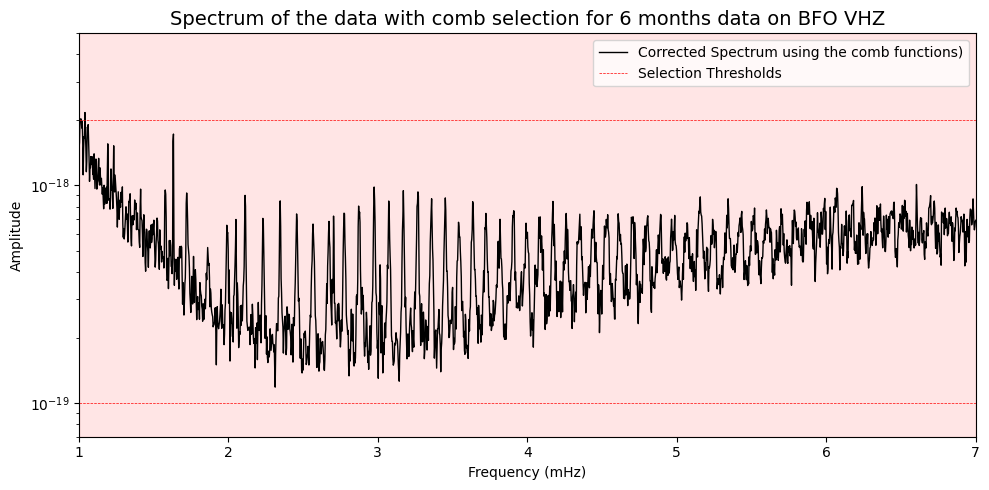

<IPython.core.display.Math object>

In [106]:
nfft = 2*L-1
spectrum = np.fft.rfft(phi)
freqs= np.fft.rfftfreq(nfft, st[0].stats.delta)  # Frequencies corresponding to the FFT
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.semilogy(freqs[:L]*1e3, np.abs(spectrum[:L])/effective_sum, color='black', lw=1, label='Corrected Spectrum using the comb functions)')
ax.set_title('Spectrum of the data with comb selection for 6 months data on BFO VHZ', fontsize=14)
ax.set_xlabel('Frequency (mHz)')
ax.set_ylabel('Amplitude')
ax.set_xlim(1, 7)
ax.set_ylim(0.7e-19,5e-18)

# Plot the thresholds

ax.axhline(1e-19, color='red', linestyle='--', lw=0.5, label=f'Selection Thresholds')
ax.axhline(2e-18, color='red', linestyle='--', lw=0.5, )
ax.fill_betweenx(ax.get_ylim(), 1, 7, color='red', alpha=0.1)
ax.legend()
plt.tight_layout()
plt.savefig("Figures/BFO2DaysRecovered.png", dpi=300)
plt.show()
from IPython.display import display, Math
display(Math(r'\large{\text{Note here that the result can be improved a lot by using more data than merely 6 months ! For the sake of smaller size file I had to limit the data to 6 months.}}'))

In [ ]:

def getPhi_batch(Correction, central_lag_list, central_lag_ij_array, fft_segments, len1, len2, batch_size=50):
    """Batch-wise computation of phi_k and zeta_k"""
    nLagBins = len(central_lag_list)
    nfft = fft_segments.shape[-1]
    print(nfft)
    n_segments = fft_segments.shape[0]
    zeta_separate = np.zeros((nLagBins, 2*len2-1))  # (nLagBins, 2*len2-1)

    lags_acf = np.arange(-len2 + 1, len2)
    lag_to_idx = {lag: k for k, lag in enumerate(central_lag_list)}
    lag_indices = {lag: np.where(lags_acf == lag)[0][0] for lag in np.unique(lags_acf)}  # faster lookup
    window_offsets = np.arange(-len1, len1+1)
    


    
    # Initialise the FFTW plan for the inverse FFT
    init = fftw.empty_aligned((batch_size, nfft), dtype='complex64')  # Allocate memory for the FFTW plan
    init[:,:] = 0  # Initialize the array to zeros
    process = fftw.builders.ifft(init)  # Create the FFTW plan for inverse FFT
    
    
    # Loop over batches
    norm_factor= 0 
    for i_start in range(0, n_segments, batch_size):
        i_end = min(i_start + batch_size, n_segments)
        batch_fft = fft_segments[i_start:i_end]  # (batch_size, 4, nfft)
        current_batch_size = batch_fft.shape[0]
        init = fftw.empty_aligned((current_batch_size, nfft), dtype='complex64')
        process = fftw.builders.irfft(init, axis=-1)
        
                # === Auto terms (i,i) ===
        for i in range(4):
            auto_spec = batch_fft[:, i, :] * np.conj(batch_fft[:, i, :])
            #inverse_fft = np.fft.ifft(auto_spec, axis=-1).real
            init[:, :] = auto_spec  # Fill the FFTW plan with the auto spectrum
            inverse_fft = process(init)  # Apply the FFTW plan to compute the inverse FFT
            inverse_fft = inverse_fft.real  # Convert to real part
            inverse_fft = np.fft.fftshift(inverse_fft, axes=-1)

            central_lags = central_lag_ij_array[i, i]
            acf_indices = np.array([lag_indices[lag] for lag in central_lags])
            central_indices = np.array([lag_to_idx[lag] for lag in central_lags])

            # Precompute all slices (vectorized extract)
            slices = inverse_fft[:, acf_indices[:, None] + window_offsets[None, :]]  # shape: (N_segments, N_lags, window_size)
            extracts = np.mean(slices, axis=0)  # shape: (N_lags, window_size)

            for k in range(len(central_lags)):
                temp = np.zeros(2*len2-1, dtype=extracts.dtype)
                start = acf_indices[k] - len1
                end = acf_indices[k] + len1 + 1
                temp[start:end] = extracts[k]
                zeta_separate[central_indices[k]] += temp

        # === Cross terms (i,j) ===
        for i in range(4):
            for j in range(i):
                cross_spec = batch_fft[:, i, :] * np.conj(batch_fft[:, j, :])
                #inverse_fft = np.fft.ifft(cross_spec, axis=-1).real
                init[:, :] = cross_spec  # Fill the FFTW plan with the cross spectrum
                inverse_fft = process(init)  # Apply the FFTW plan to compute the inverse FFT
                inverse_fft = inverse_fft.real  # Convert to real part
                # Shift the zero frequency component to the center
                inverse_fft = np.fft.fftshift(inverse_fft, axes=-1)

                central_lags = central_lag_ij_array[i, j]
                #acf_indices = np.array([lag_indices[lag] for lag in central_lags])
                acf_indices = np.array([np.where(lags_acf == lag)[0][0] for lag in central_lags])
                central_indices = np.array([lag_to_idx[lag] for lag in central_lags])
                central_indices_flip = np.array([lag_to_idx[-lag] for lag in central_lags])
                #slices = inverse_fft[:, acf_indices[:, None] + window_offsets[None, :]]  # shape: (N_segments, N_lags, 2*len1+1)


                valid_mask = (acf_indices - len1 >= 0) & (acf_indices + len1 < inverse_fft.shape[1])
                acf_indices = acf_indices[valid_mask]
                central_indices = central_indices[valid_mask]
                central_indices_flip = central_indices_flip[valid_mask]

                combined_indices = acf_indices[:, None] + window_offsets[None, :]
                slices = inverse_fft[:, combined_indices]  # shape: (N_segments, N_lags, window_size)
                
                extracts = np.mean(slices, axis=0)  # shape: (N_lags, window_size)

                for k in range(len(acf_indices)):
                    temp = np.zeros(2*len2-1, dtype=extracts.dtype)

                    start_in_ifft = acf_indices[k] - len1
                    end_in_ifft   = acf_indices[k] + len1 + 1

                    start_in_temp = max(0, start_in_ifft)
                    end_in_temp   = min(2*len2-1, end_in_ifft)

                    start_in_extract = start_in_temp - start_in_ifft
                    end_in_extract   = start_in_extract + (end_in_temp - start_in_temp)

                    # Now safely assign
                    temp[start_in_temp:end_in_temp] = extracts[k, start_in_extract:end_in_extract]
                    zeta_separate[central_indices[k]] += temp
                    zeta_separate[central_indices_flip[k]] += np.flip(temp)
        
        norm_factor+=1

    # Final assembly of zeta_k and phi_k
    zeta_k = np.zeros((2*len2-1))
    phi_k  = np.zeros((2*len2-1))

    for lag in central_lag_list:
        index = lag_to_idx[lag]
        zeta_k += zeta_separate[index]
        phi_k  += zeta_separate[index] / Correction[index]
        
   
    ## Normalize phi_k and zeta_k by the number of batches
    phi_k /= norm_factor
    zeta_k /= norm_factor

    return phi_k, zeta_k
def ProcessData(data,Q,ell,L,selection_array,selection_array_i3,Correction,central_lag_list,central_lag_ij_array):
    fftw.interfaces.cache.enable()  # cache FFT plans
    init = fftw.empty_aligned((Q,4,2*L-1), dtype='float32') # need the -1 because the last comb in the data might not be full and thus lead to error.
    init[:]= 0  # Initialize the array to zeros
    process = fftw.builders.fft(init)

    combs= GenerateCombs(ell,L)  # Generate the comb functions for Q segments, each of length ell and total length L

    mute_mask = np.ones((Q, 4, L))

    npts_used = (L-ell//2)*(Q+1)

    for i in range(4):
        if i<3:
            selection_list = selection_array[:, i]
            len_ = selection_list.shape[1]  # Length of the selection list for the current comb
        else:
            selection_list = selection_array_i3[:,0]
            len_ = selection_list.shape[1]
        for j in range(len_):
            mute_mask[:, i, i*ell//2 + 2*j*ell:i*ell//2 + 2*(j+1)*ell] *= selection_list[:,j][:, np.newaxis]
        
    #### VECTORIZED OPERATION FOR THE SEGMENT MUTING ####
    comb_array = np.tile(combs, (Q, 1, 1))  # (Q, 4, L)
    comb_array *= mute_mask  # now all Q combs are pre-masked

    # Roll the data segments according to the shifts

    step=(L - ell//2) # Take the overlap into account (half sub-segment length to ensure a flat equivalent windowing taper)
    data_rolled = np.zeros((Q, 4, L))
    segments = sliding_window_view(data[:npts_used], window_shape=L)[::step].copy()
    for q in range(Q):
        data_rolled[q] = np.tile(segments[q], (4, 1))  # shape (Q, 4, L)

    ### Vectorized calculation of the fourrier transforms
    segments = comb_array * data_rolled  # shape (Q, 4, L)
    #fft_segments = fftw.interfaces.numpy_fft.fft(np.pad(segments, ((0,0),(0,0),(0,L-1))), axis=-1) #Shape (Q, 4, 2*L-1)
    init[:,:,0:L] = segments  # Fill the FFTW plan with the segments
    fft_segments = process(init)  # Apply the FFTW plan to compute the FFT
    print("FFT segments shape:", fft_segments.shape)
    phi,zeta_k = getPhi_batch(Correction,central_lag_list, central_lag_ij_array,fft_segments, ell, L,batch_size=100)
    
    return phi,zeta_k